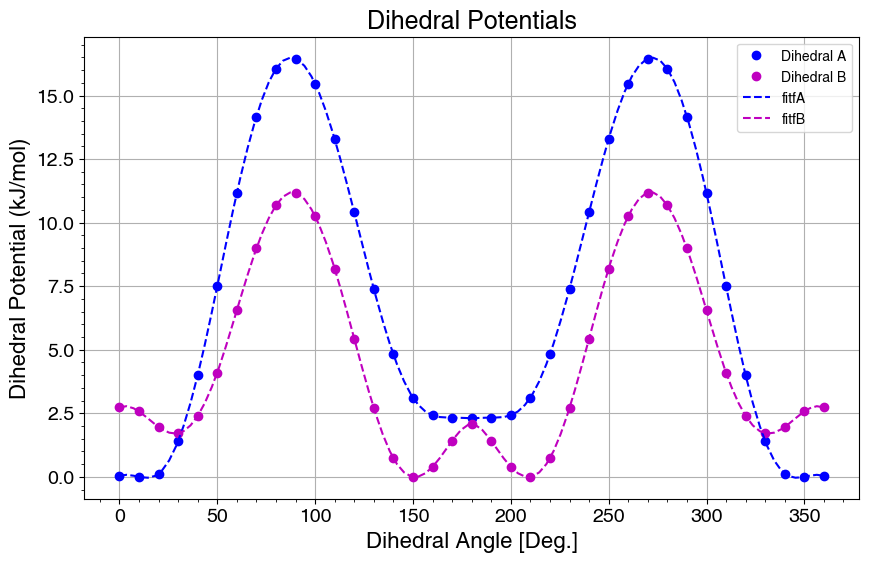

In [ ]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad, cumulative_trapezoid
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from joblib import Parallel, delayed
import scipy.constants as constants

# Energy in kcal/mol
dihedralA_kcal_mol = np.array([[180, 0.551967], [170, 0.557568],
                               [160, 0.57842], [150, 0.743988], [140, 1.15127],
                               [130, 1.76722], [120, 2.48711], [110, 3.17616],
                               [100, 3.6976], [90, 3.93171], [80, 3.8368],
                               [70, 3.38603], [60, 2.66725], [50, 1.79179],
                               [40, 0.954215], [30, 0.334189], [20, 0.0295074],
                               [10, 0], [0, 0.00945115]])
dihedralB_kcal_mol = np.array([[180, 0.496007], [170, 0.338429],
                               [160, 0.0933325], [150, 0], [140, 0.17495],
                               [130, 0.647714], [120, 1.29963], [110, 1.9583],
                               [100, 2.45073], [90, 2.6726], [80, 2.55251],
                               [70, 2.1469], [60, 1.56547], [50, 0.979727],
                               [40, 0.572042], [30, 0.409372], [20, 0.469453],
                               [10, 0.615015], [0, 0.652945]])

# Convert energy from kcal/mol to kJ/mol
conversion_factor = 4.184
dihedralA = np.copy(dihedralA_kcal_mol)
dihedralA[:, 1] *= conversion_factor
dihedralB = np.copy(dihedralB_kcal_mol)
dihedralB[:, 1] *= conversion_factor

# Create symmetric dihedral angle data
newa = np.copy(dihedralA)
newa[:, 0] = newa[:, 0] * -1 + 360
newb = np.copy(dihedralB)
newb[:, 0] = newb[:, 0] * -1 + 360
dihedralA = np.unique(np.concatenate((dihedralA, newa), axis=0), axis=0)
dihedralB = np.unique(np.concatenate((dihedralB, newb), axis=0), axis=0)

# Create interpolation functions
fitfA = interp1d(dihedralA[:, 0],
                 dihedralA[:, 1],
                 kind='cubic',
                 fill_value="extrapolate")
fitfB = interp1d(dihedralB[:, 0],
                 dihedralB[:, 1],
                 kind='cubic',
                 fill_value="extrapolate")

# Plot the dihedral potentials
plt.figure(figsize=(10, 6))
plt.plot(dihedralA[:, 0], dihedralA[:, 1], 'bo', label='Dihedral A')
plt.plot(dihedralB[:, 0], dihedralB[:, 1], 'mo', label='Dihedral B')
x_plot = np.linspace(0, 360, 100)
plt.plot(x_plot, fitfA(x_plot), 'b--', label='fitfA')
plt.plot(x_plot, fitfB(x_plot), 'm--', label='fitfB')
plt.xlabel("Dihedral Angle [Deg.]", fontsize=16, fontfamily="Helvetica")
plt.ylabel("Dihedral Potential (kJ/mol)", fontsize=16, fontfamily="Helvetica")
plt.xticks(fontsize=14, fontfamily="Helvetica")
plt.yticks(fontsize=14, fontfamily="Helvetica")
plt.legend(fontsize=14, prop={'family': 'Helvetica'})
plt.grid(True)
plt.minorticks_on()
plt.title("Dihedral Potentials", fontsize=18, fontfamily="Helvetica")
plt.show()

kTval (kJ/mol): 5.820123832707269
normValA: 154.06885562263417
normValB: 196.00242569102204


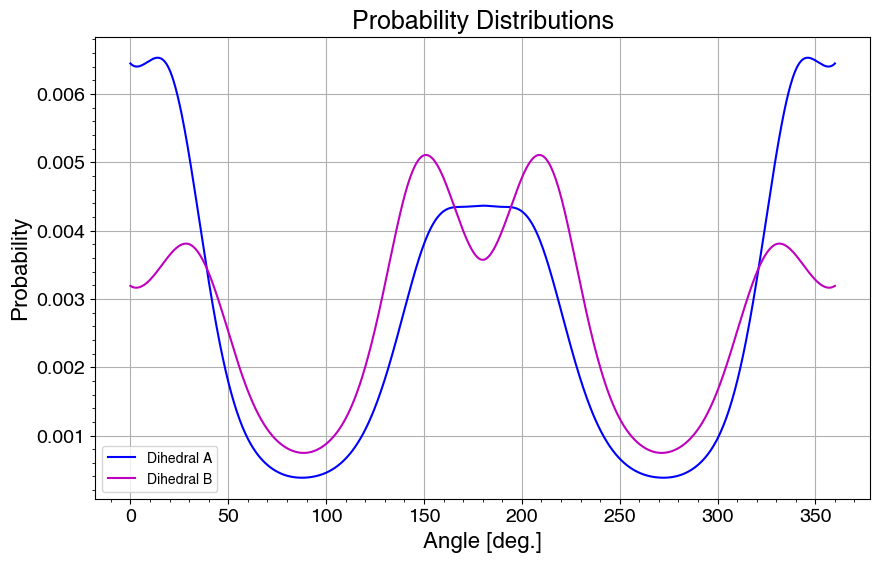

In [11]:
# Temperature and kT value
temperature = 700  # K
k = constants.Boltzmann  # J/K
avogadro = constants.Avogadro  # mol^-1
kTval_J = temperature * k
kTval_kJ_mol = kTval_J * avogadro / 1000
print(f"kTval (kJ/mol): {kTval_kJ_mol}")

# Normalization constants
def boltzmann_factor(energy, kT):
    return np.exp(-energy / kT)

normValA_integrand = lambda x: boltzmann_factor(fitfA(x), kTval_kJ_mol)
normValB_integrand = lambda x: boltzmann_factor(fitfB(x), kTval_kJ_mol)

normValA, _ = quad(normValA_integrand, 0, 180)
normValA *= 2
normValB, _ = quad(normValB_integrand, 0, 180)
normValB *= 2

print(f"normValA: {normValA}")
print(f"normValB: {normValB}")

# Probability distribution functions
def probA(x, kT, norm):
    return boltzmann_factor(fitfA(x), kT) / norm

def probB(x, kT, norm):
    return boltzmann_factor(fitfB(x), kT) / norm

# Plot probability distributions
x_plot = np.linspace(0, 360, 1000)
probA_vals = probA(x_plot, kTval_kJ_mol, normValA)
probB_vals = probB(x_plot, kTval_kJ_mol, normValB)

plt.figure(figsize=(10, 6))
plt.plot(x_plot, probA_vals, 'b-', label='Dihedral A')
plt.plot(x_plot, probB_vals, 'm-', label='Dihedral B')
plt.xlabel("Angle [deg.]", fontsize=16, fontfamily="Helvetica")
plt.ylabel("Probability", fontsize=16, fontfamily="Helvetica")
plt.xticks(fontsize=14, fontfamily="Helvetica")
plt.yticks(fontsize=14, fontfamily="Helvetica")
plt.legend(fontsize=14, prop={'family': 'Helvetica'})
plt.grid(True)
plt.title("Probability Distributions", fontsize=18, fontfamily="Helvetica")
plt.minorticks_on()
plt.show()

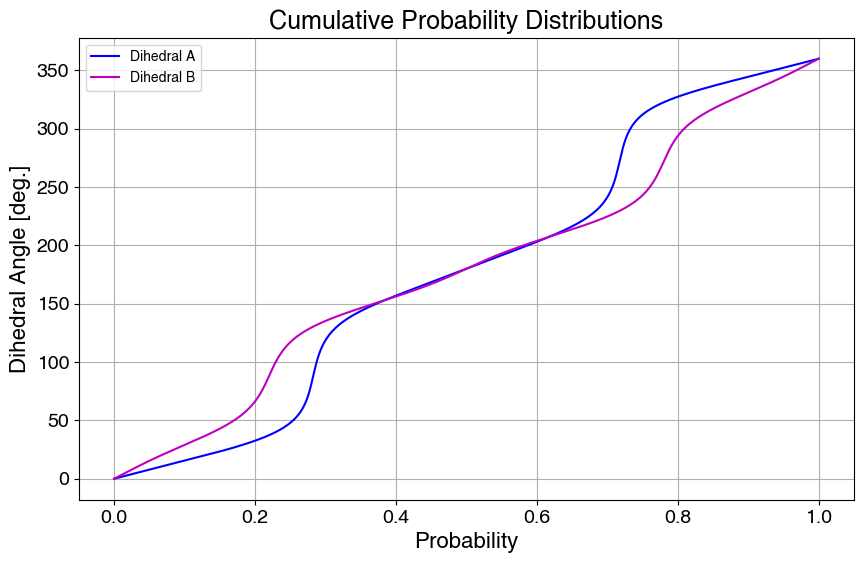

In [12]:
# Cumulative probability tables
num_points = 361
angles = np.linspace(0, 360, num_points)
pIntTableA = np.zeros((num_points, 2))
pIntTableB = np.zeros((num_points, 2))

cumulative_prob_A = [quad(probA, 0, x, args=(kTval_kJ_mol, normValA))[0] for x in angles]
cumulative_prob_B = [quad(probB, 0, x, args=(kTval_kJ_mol, normValB))[0] for x in angles]

pIntTableA[:, 0] = cumulative_prob_A
pIntTableA[:, 1] = angles
pIntTableB[:, 0] = cumulative_prob_B
pIntTableB[:, 1] = angles

# Plot cumulative probability distributions
plt.figure(figsize=(10, 6))
plt.plot(pIntTableA[:, 0], pIntTableA[:, 1], 'b-', label='Dihedral A')
plt.plot(pIntTableB[:, 0], pIntTableB[:, 1], 'm-', label='Dihedral B')
plt.xlabel("Probability", fontsize=16, fontfamily="Helvetica")
plt.ylabel("Dihedral Angle [deg.]", fontsize=16, fontfamily="Helvetica")
plt.xticks(fontsize=14, fontfamily="Helvetica")
plt.yticks(fontsize=14, fontfamily="Helvetica")
plt.legend(fontsize=14, prop={'family': 'Helvetica'})
plt.grid(True)
plt.title("Cumulative Probability Distributions", fontsize=18, fontfamily="Helvetica")
plt.show()

In [13]:
# Inverse cumulative probability functions
thA = interp1d(pIntTableA[:, 0],
               pIntTableA[:, 1],
               kind='cubic',
               bounds_error=False,
               fill_value=(0, 360))
thB = interp1d(pIntTableB[:, 0],
               pIntTableB[:, 1],
               kind='cubic',
               bounds_error=False,
               fill_value=(0, 360))

# 角度不对，待处理
# Chain geometry
lbb = 6.951
lcc1 = 1.466
lcsc = 2.540
lcc2 = 1.456
lb = 2.967
lcc3 = 1.459
lcsc2 = 2.513
lcc4 = 1.500
l = np.array([[lbb, lcc1, lcsc, lcc2, lb, lcc3, lcsc2, lcc4]])
# two all zero rows
zero_arrays = np.zeros((2, l.shape[1]))
l_array = np.vstack((l, zero_arrays)).T

angle_value_1 = np.deg2rad(-11)
angle_value_2 = np.deg2rad(14)
angle_value_3 = np.deg2rad(-1.4)
Angle = [
    angle_value_1, angle_value_2, angle_value_2, angle_value_3,
    angle_value_3, angle_value_2, angle_value_2, angle_value_1
]

def angle_sum(a, length_angle):
    a_np = np.array(a)
    len_a = len(a_np)
    n_repeats = (length_angle + len_a - 1) // len_a  # Calculate how many times to repeat 'a'
    repeated_a = np.tile(a_np, n_repeats)
    cumulative_sum = np.cumsum(repeated_a)
    angle = cumulative_sum[:length_angle]
    return angle

def rotation_matrix(axis, angle):
    """
    Return the rotation matrix associated with 
    counterclockwise rotation about the given 
    axis by angle radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.linalg.norm(axis)
    a = np.cos(angle / 2.0)
    b, c, d = -axis * np.sin(angle / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

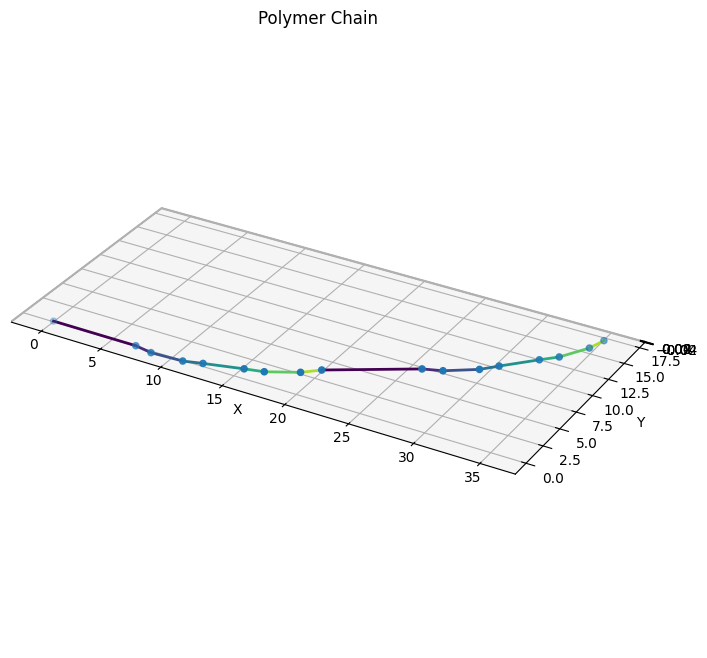

In [14]:
# v[i_] :=If[i>1,
# RotationMatrix[Angle[[Mod[i-1,8,1]]]].v[i-1]*l[[Mod[i,8,1]]]/l[[Mod[i-1,8,1]]],l[[1]]{1,0}]
def chain(n):
    angle_new = angle_sum(Angle, n)
    segments = [
        np.dot(rotation_matrix([0, 0, 1], angle_new[i]),
               l_array[(i + 1) % l.shape[1]]) for i in range(n - 1)
    ]
    return np.cumsum(np.vstack((np.array([[0, 0, 0], l_array[0]]), segments)),
                     axis=0)


def drawChain(pts):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    pts_array = np.array(pts)
    ax.scatter(pts_array[:, 0], pts_array[:, 1], pts_array[:, 2], s=20)
    for i in range(len(pts) - 1):
        ax.plot([pts[i][0], pts[i + 1][0]], [pts[i][1], pts[i + 1][1]],
                [pts[i][2], pts[i + 1][2]],
                color=plt.get_cmap('viridis')(i % 8 * (256 // 8)),
                linewidth=2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_aspect('equal')
    # ax.view_init(elev=90, azim=0)
    plt.title("Polymer Chain")
    plt.show()


drawChain(chain(16))  # This will show a static chain

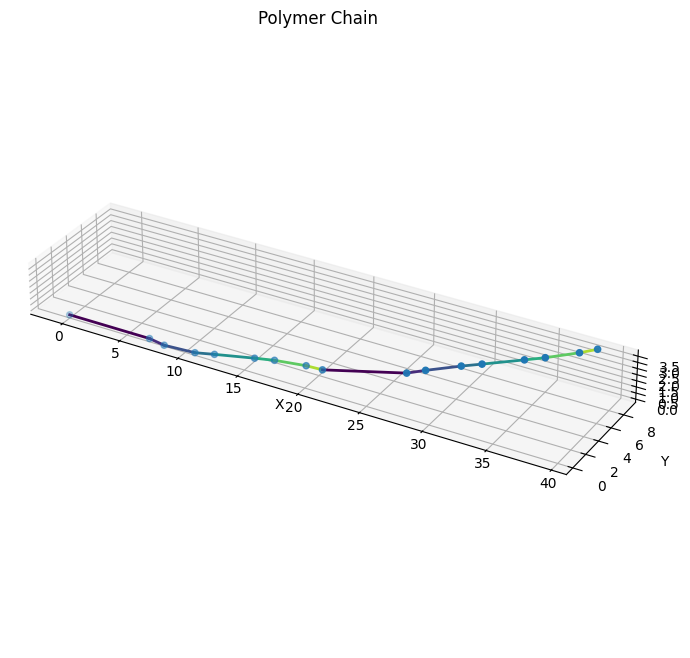

In [ ]:
def dihedralRotate(pts, nb, theta_deg):
    if nb % 2 == 0:
        theta_rad = np.deg2rad(theta_deg)
        origin = pts[nb].copy()
        vec = pts[nb] - pts[nb - 1]
        vec_norm = np.linalg.norm(vec)
        axis = vec / vec_norm
        # Construct rotation matrix using the provided rotation_matrix function
        rot = rotation_matrix(axis, theta_rad)
        rotated_pts = np.copy(pts)
        rotated_pts[nb + 1:len(pts)] = np.dot(rotated_pts[nb + 1:len(pts)] - origin, rot.T) + origin
        return rotated_pts
    else:
        raise ValueError(f"nb must be an even index between 1 and len(pts)-2, but got {nb}")

def cosVals(pts):
    cos_values = []
    v2 = pts[2] - pts[1]
    norm_v2 = np.linalg.norm(v2)
    # Need replae for loop with vectorized operation
    for k in range(2, len(pts) + 1, 8):
        v1 = pts[k] - pts[k - 1]
        norm_v1 = np.linalg.norm(v1)
        dot_product = np.dot(v1, v2)
        cos_values.append(dot_product / (norm_v1 * norm_v2))
    return np.array(cos_values)

def randomRotate(pts):
    newpts = np.copy(pts)
    n_points = len(pts)
    for k in range(2, n_points - 1, 2):
        mod_k = k % 8
        if mod_k == 2 or mod_k == 0: 
            newpts = dihedralRotate(newpts, k, thB(np.random.rand()))
        elif mod_k == 4 or mod_k == 6: 
            newpts = dihedralRotate(newpts, k, thA(np.random.rand()))
    return newpts

drawChain(randomRotate(chain(16)))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 4616 tasks      | elapsed:    9.3s
[Parallel(n_jobs=4)]: Done 12616 tasks      | elapsed:   23.2s
[Parallel(n_jobs=4)]: Done 23816 tasks      | elapsed:   43.5s
[Parallel(n_jobs=4)]: Done 38216 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 50000 out of 50000 | elapsed:  1.5min finished


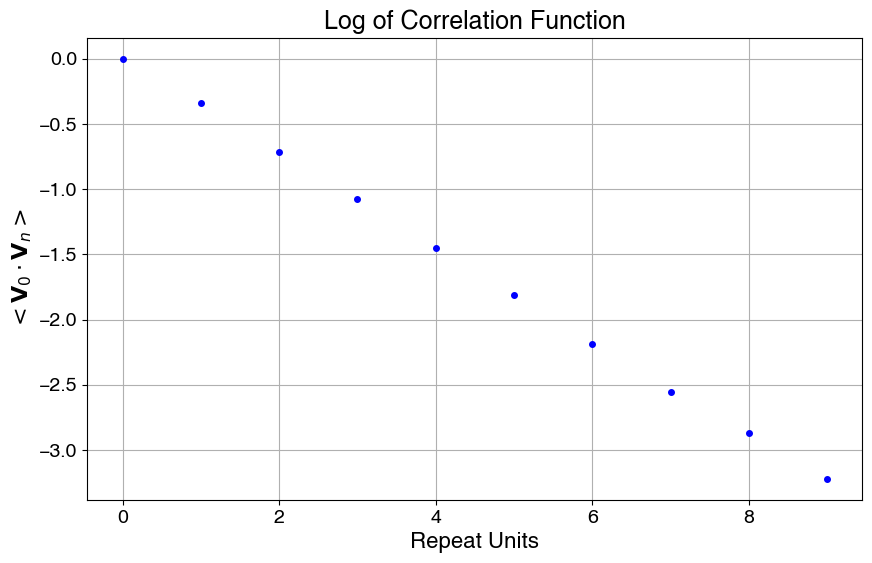

logFitPFTBT'[x] (slope): -0.3609028414579234
Correlation length: 2.7708288357064297


In [16]:
# Correlation function calculation
n_repeat_units = 20
chain_length = n_repeat_units * 8
ch = chain(chain_length)
n_samples = 50000

def calculate_cos_vals(i):
    return cosVals(randomRotate(np.copy(ch)))

import psutil
n_jobs = psutil.cpu_count(logical=False)
cosList2 = Parallel(n_jobs=n_jobs, verbose=1)(delayed(calculate_cos_vals)(i) for i in range(n_samples))
corr2 = np.mean(np.array(cosList2), axis=0)

# Plot correlation function
plt.figure(figsize=(10, 6))
repeat_units = np.arange(len(corr2))
plt.plot(repeat_units[:10], np.log(corr2[:10]), 'bo', markersize=4, label='Log Correlation')
plt.xlabel("Repeat Units", fontsize=16, fontfamily="Helvetica")
plt.ylabel(r'$<\mathbf{V}_0 \cdot \mathbf{V}_n>$', fontsize=16, fontfamily="Helvetica")
plt.xticks(fontsize=14, fontfamily="Helvetica")
plt.yticks(fontsize=14, fontfamily="Helvetica")
plt.grid(True)
plt.title("Log of Correlation Function", fontsize=18, fontfamily="Helvetica")
plt.show()

# Fit correlation function
def linear_func(x, a, b):
    return a + b * x

popt, pcov = curve_fit(linear_func, repeat_units[:10], np.log(corr2[:10]))
logFitPFTBT_prime = popt[1]
persistence_length = -1 / logFitPFTBT_prime
print(f"logFitPFTBT'[x] (slope): {logFitPFTBT_prime}")
print(f"Correlation length: {persistence_length}")